In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [3]:
face_cascade = cv2.CascadeClassifier('./cascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./cascades/haarcascade_eye.xml')

In [4]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [4]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], (kernel_size, kernel_size), input_shape=input_shape,
                          padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], (kernel_size, kernel_size), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [5]:
input_dim = (1, 56, 46)
print(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
#base_network.summary()

(1, 56, 46)


In [6]:
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
model = Model(inputs=[img_a, img_b], outputs=distance)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           191618      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [7]:
model.load_weights('model_siamese.h5')

(56, 46)
(56, 46)


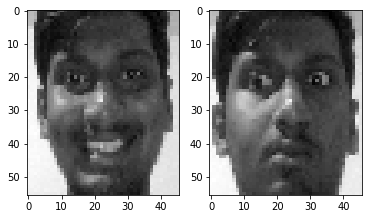

In [8]:
shu = read_image('att-database-of-faces/s40/1.pgm')
shu = cv2.resize(shu, (46,56))
print(shu.shape)
plt.subplot(1, 2, 1)
plt.imshow(shu, 'gray')

img2 = plt.imread("C:/Users/hp/Desktop/facerec/image92.png")
img2 = cv2.resize(img2, (46,56))
print(img2.shape)
plt.subplot(1,2,2)
plt.imshow(img2, 'gray')

In [9]:
pred = model.predict([shu.reshape(1,1,56,46)/255, img2.reshape(1,1,56,46)])
pred#[i]

array([[0.01727612]], dtype=float32)

(56, 46)
(56, 46)


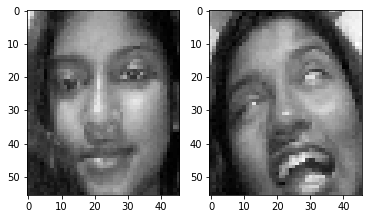

In [10]:
jhal = read_image('att-database-of-faces/s39/3.pgm')
jhal = cv2.resize(jhal, (46,56))
print(jhal.shape)
plt.subplot(1, 2, 1)
plt.imshow(jhal, 'gray')

img3 = plt.imread("C:/Users/hp/Desktop/facerec/image95.png")
img3 = cv2.resize(img3, (46,56))
print(img3.shape)
plt.subplot(1,2,2)
plt.imshow(img3, 'gray')

In [11]:
pred = model.predict([jhal.reshape(1,1,56,46)/255, img3.reshape(1,1,56,46)])
pred#[i]

array([[0.00817878]], dtype=float32)

In [12]:
pred = model.predict([jhal.reshape(1,1,56,46)/255, img2.reshape(1,1,56,46)])
pred#[i]

array([[0.62437105]], dtype=float32)

In [13]:
pred = model.predict([shu.reshape(1,1,56,46)/255, img3.reshape(1,1,56,46)])
pred#[i]

array([[0.6126646]], dtype=float32)

In [14]:
def compare(base, img):
    base = cv2.resize(base, (46,56))
    img = cv2.resize(img, (46,56))
    pred = model.predict([base.reshape(1,1,56,46)/255, img.reshape(1,1,56,46)/255]) 
    return (pred < 0.2)

In [17]:
def detect(gray, frame):
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    roi_gray = np.random.rand(100,100)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        if compare(shu, roi_gray):
            cv2.putText(frame,'Shubham',(x,y),cv2.FONT_HERSHEY_COMPLEX,.5,(0,0,0),1)
        if compare(jhal, roi_gray):
            cv2.putText(frame,'Jhalak',(x,y),cv2.FONT_HERSHEY_COMPLEX,.5,(0,0,0),1)
#         eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 3)
#         for (ex, ey, ew, eh) in eyes:
#             cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
    return frame

In [19]:
video_capture = cv2.VideoCapture(0)
# fourcc = cv2.VideoWriter_fourcc(*'XVID') 
# out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480)) 
while True:
    _, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    canvas = detect(gray, frame)
    cv2.imshow('Video', canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
#     out.write(canvas)
    
video_capture.release()
# out.release()  
cv2.destroyAllWindows()

In [98]:
gray.shape

(480, 640)

(56, 46)
(56, 46)


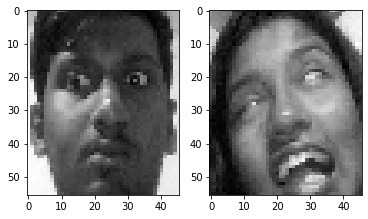

In [100]:
img = plt.imread("image92.png")#read_image('att-database-of-faces/s40/3.pgm')
img = cv2.resize(img, (46,56))
print(img.shape)
plt.subplot(1, 2, 1)
plt.imshow(img, 'gray')

img2 = plt.imread("image95.png")
img2 = cv2.resize(img2, (46,56))
print(img.shape)
plt.subplot(1,2,2)
plt.imshow(img2, 'gray')

In [89]:
pred = model.predict([img.reshape(1,1,56,46), img2.reshape(1,1,56,46)])
pred#[i]

array([[0.6230878]], dtype=float32)

(56, 46)
(56, 46)


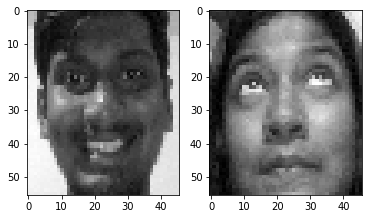

In [81]:
img3 = read_image('att-database-of-faces/s40/1.pgm')
img3 = cv2.resize(img3, (46,56))
print(img3.shape)
plt.subplot(1, 2, 1)
plt.imshow(img3, 'gray')

img4 = read_image('att-database-of-faces/s39/1.pgm') #plt.imread("image92.png")
img4 = cv2.resize(img4, (46,56))
print(img4.shape)
plt.subplot(1,2,2)
plt.imshow(img4, 'gray')

In [82]:
pred = model.predict([img4.reshape(1,1,56,46)/255, img3.reshape(1,1,56,46)/255])
pred#[i]

array([[0.6162139]], dtype=float32)

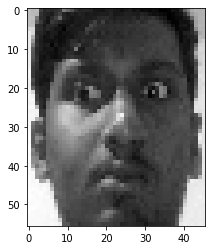

In [106]:
plt.imshow(img,'gray')

In [99]:
img3

array([[158, 164, 162, ..., 149, 150, 148],
       [159, 162, 151, ..., 146, 151, 153],
       [161, 164, 156, ..., 154, 151, 152],
       ...,
       [209, 211, 207, ..., 197, 192, 197],
       [207, 207, 210, ..., 195, 196, 193],
       [203, 205, 204, ..., 194, 193, 196]], dtype=uint8)

In [5]:
jhal = read_image('image70.pgm')
jhal = cv2.resize(jhal, (46,56))
print(jhal.shape)
plt.subplot(1, 2, 1)
plt.imshow(jhal, 'gray')

AttributeError: 'NoneType' object has no attribute 'groups'

In [6]:
img = cv2.imread('image76.pgm')

In [9]:
img.shape

(196, 196, 3)